In [42]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
import pandas as pd

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import SplineTransformer
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [15]:
df = pd.read_csv("../DATA/global_economy.csv")
df.ds = pd.to_datetime(df.ds, format="%Y")
df = df[df.unique_id == "Afghanistan"]
df = df[["unique_id", "ds", "Population"]]
df = df.rename({"Population": "y"}, axis=1)

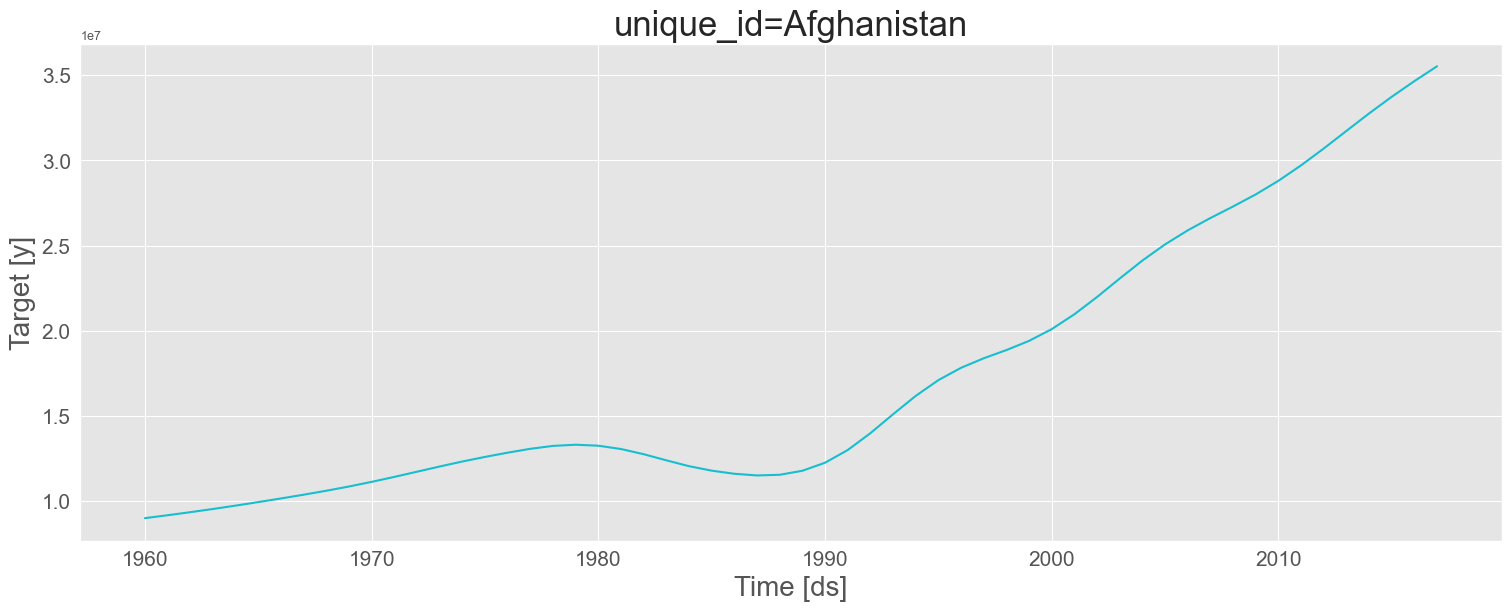

In [16]:
plot_series(df)

In [122]:
new_df = trend(df, freq="Y")[0]
X = pd.DataFrame(new_df.trend)
y = new_df.y
linreg = LinearRegression().fit(X, y)

knots = np.array([[0], [20], [29], [57]])
piecewise = SplineTransformer(
    degree=1, include_bias=False, knots=knots, extrapolation="continue"
)

X_piece = piecewise.fit_transform(X)
piece_reg = LinearRegression().fit(X_piece, y)

Y = pd.Series(range(58, 68))
Y_piece = piecewise.transform(pd.DataFrame(Y))

<Axes: xlabel='None', ylabel='y'>

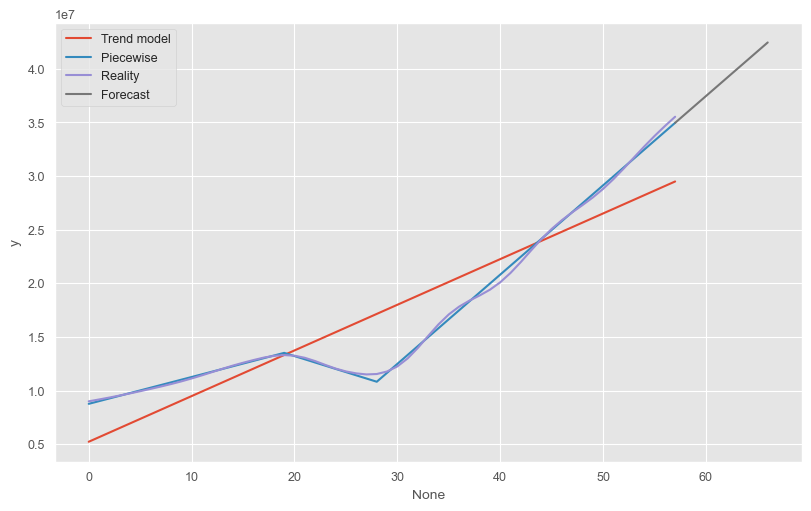

In [123]:
sns.lineplot(linreg.predict(X), label="Trend model")
sns.lineplot(piece_reg.predict(X_piece), label="Piecewise")
sns.lineplot(new_df.y, label="Reality")
sns.lineplot(x=Y - 1, y=piece_reg.predict(Y_piece), label="Forecast")

In [110]:
Y_piece = piecewise.transform(pd.DataFrame(Y))

array([[ 0.        ,  0.        , -0.03571429],
       [ 0.        ,  0.        , -0.07142857],
       [ 0.        ,  0.        , -0.10714286],
       [ 0.        ,  0.        , -0.14285714],
       [ 0.        ,  0.        , -0.17857143]])